# Data Source

Data Source get with select :
```sql
-- Агрегирование затрат на кампанию по месяцам
select DATE_TRUNC('month', campaign_start_dtm_ts) AS month,  
	SUM(
		case 
			when currency = 'USD' then campaign_cost::numeric *96
			else campaign_cost::numeric
		end
	) AS total_cost_rub,
	campaign_type, 
	source_medium,
	count(user_id) user_id_cnt
FROM adv_data
GROUP by  DATE_TRUNC('month', campaign_start_dtm_ts), campaign_type, source_medium
ORDER BY month, campaign_type
;
```



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Загрузка данных из CSV файла
adv = pd.read_csv('adv_data_aggregation_202405282030.csv', delimiter=';')

# Преобразование столбца 'month' в datetime формат
adv['month'] = pd.to_datetime(adv['month'])
# Разделение столбца 'source_medium' на два столбца 'source' и 'medium'
adv[['source', 'medium']] = adv['source_medium'].str.split(' / ', expand=True)
print(adv.head())

       month  total_cost_rub campaign_type             source_medium  \
0 2022-10-01          197.86         click      android / mobile_app   
1 2022-10-01          187.63         click            bing / organic   
2 2022-10-01            0.00         click             email / email   
3 2022-10-01          218.66         click  finance.rambler.ru / cpm   
4 2022-10-01          635.54         click          google / organic   

   user_id_cnt              source      medium  
0            3             android  mobile_app  
1            2                bing     organic  
2            1               email       email  
3            1  finance.rambler.ru         cpm  
4            9              google     organic  


In [6]:
# Загрузка данных из CSV файла
event = pd.read_csv('event_data_aggregation_202405282037.csv', delimiter=';')

# Преобразование столбца 'month' в datetime формат
event['month'] = pd.to_datetime(event['month'])
print(event.head())

       month  total_payout_rub  event_type product_type event_status  \
0 2023-02-01        1614730.40       click     deposits          NaN   
1 2023-02-01        3899051.72       click         loan          NaN   
2 2023-02-01         976006.28       click     mortgage          NaN   
3 2023-02-01         308895.60  conversion     deposits      approve   
4 2023-02-01         227974.80  conversion     deposits         deal   

   user_id_cnt  
0        33249  
1        79622  
2        20149  
3         1850  
4         3341  


In [52]:
# Группировка по месяцам, типу продукта и типу события
grouped = event.groupby([event['month'].dt.to_period('M'), 'product_type', 'event_type'])['user_id_cnt'].sum().unstack().fillna(0)

# Подсчет общего количества касаний и количества конверсий за каждый месяц и тип продукта
grouped['total_touches'] = grouped.sum(axis=1)
grouped['total_conversions'] = grouped['conversion']

# Расчет среднего количества касаний на одну конверсию за каждый месяц и тип продукта
grouped['avg_touches_per_conversion'] = grouped['total_touches'] / grouped['total_conversions']

# Заполнение бесконечных значений нулями (если нет конверсий)
grouped['avg_touches_per_conversion'] = grouped['avg_touches_per_conversion'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Сброс уровня группировки для добавления столбца месяца
grouped_reset = grouped.reset_index()

# Преобразование месяца в строковый формат для отображения
grouped_reset['month'] = grouped_reset['month'].astype(str)

# Вывод окончательных данных
print(grouped_reset[['month', 'product_type', 'total_touches', 'total_conversions', 'avg_touches_per_conversion']])


event_type    month product_type  total_touches  total_conversions  \
0           2023-02     deposits         173472               7164   
1           2023-02         loan         416789              17526   
2           2023-02     mortgage         104096               4287   
3           2023-03     deposits         212896               8813   
4           2023-03         loan         510981              21783   
5           2023-03     mortgage         127396               5588   
6           2023-04     deposits         205425               8532   
7           2023-04         loan         491830              20506   
8           2023-04     mortgage         123139               5245   
9           2023-05     deposits         213245               8622   
10          2023-05         loan         509623              21496   
11          2023-05     mortgage         127530               5445   
12          2023-06     deposits         204274               8367   
13          2023-06 

In [54]:
grouped_reset.describe()

event_type,click,conversion,show,total_touches,total_conversions,avg_touches_per_conversion
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,49116.282051,10775.512821,196518.461538,256410.256410,10775.512821,23.876866
std,32609.456705,7218.491291,130578.014579,170402.881404,7218.491291,0.466132
min,2087.000000,441.000000,8443.000000,10971.000000,441.000000,22.798139
25%,24406.500000,5430.000000,97421.000000,127338.000000,5430.000000,23.490538
50%,39376.000000,8532.000000,157628.000000,205425.000000,8532.000000,23.940649
75%,94274.000000,20598.500000,377186.000000,492285.000000,20598.500000,24.215874
max,97953.000000,21946.000000,391485.000000,511119.000000,21946.000000,24.877551


In [49]:
event_grouped

event_type            click  conversion    show
month   product_type                           
2023-02 deposits      33249        7164  133059
        loan          79622       17526  319641
        mortgage      20149        4287   79660
2023-03 deposits      40719        8813  163364
        loan          97929       21783  391269
        mortgage      24434        5588   97374
2023-04 deposits      39376        8532  157517
        loan          94272       20506  377052
        mortgage      23697        5245   94197
2023-05 deposits      40880        8622  163743
        loan          97480       21496  390647
        mortgage      24423        5445   97662
2023-06 deposits      39056        8367  156851
        loan          94276       20963  377501
        mortgage      23777        5168   94526
2023-07 deposits      40584        8945  162655
        loan          97411       21297  391156
        mortgage      24648        5438   97889
2023-08 deposits      40557        8652  161989
        loan          97227       21141  389817
        mortgage      24402        5447   97468
2023-09 deposits      39257        8430  157163
        loan          94336       21373  377320
        mortgage      23429        5203   94039
2023-10 deposits      40589        8732  162500
        loan          97688       21946  391485
        mortgage      24411        5259   97689
2023-11 deposits      39307        8487  157628
        loan          94808       20691  378444
        mortgage      23695        5277   94141
2023-12 deposits      40664        8853  162797
        loan          97953       21813  390775
        mortgage      24278        5422   97079
2024-01 deposits      40576        8682  162922
        loan          97787       21198  390850
        mortgage      24628        5450   98017
2024-02 deposits       3425         759   14121
        loan           8449        1804   33770
        mortgage       2087         441    8443

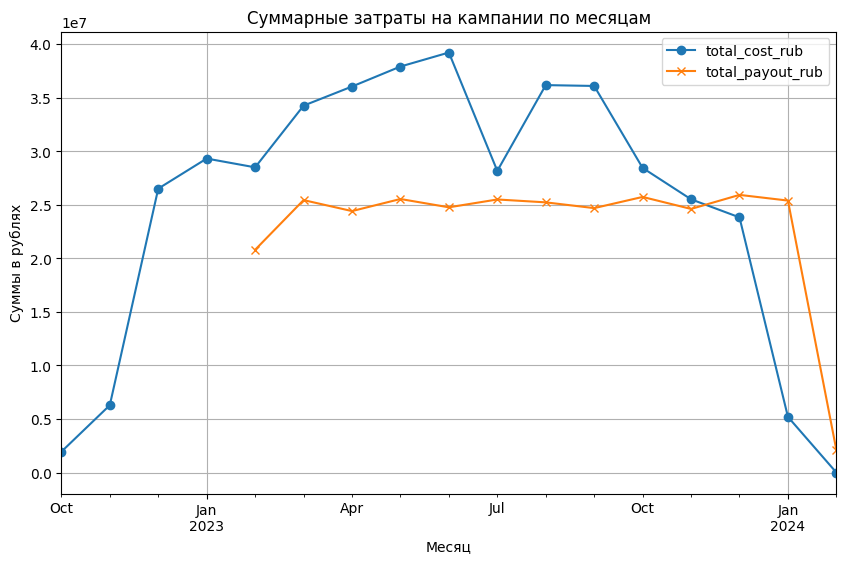

In [25]:
# Группировка данных по месяцам и суммирование выплат
monthly_event_payouts = event.groupby('month')['total_payout_rub'].sum()

# Группировка данных по месяцам и суммирование затрат
monthly_adv_costs = adv.groupby('month')['total_cost_rub'].sum()

# Построение графика суммарных затрат по месяцам
plt.figure(figsize=(10, 6))
monthly_adv_costs.plot(kind='line', marker='o')
monthly_event_payouts.plot(kind='line', marker='x')
plt.title('Суммарные затраты на кампании по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Суммы в рублях')
plt.grid(True)
plt.legend()
plt.show()


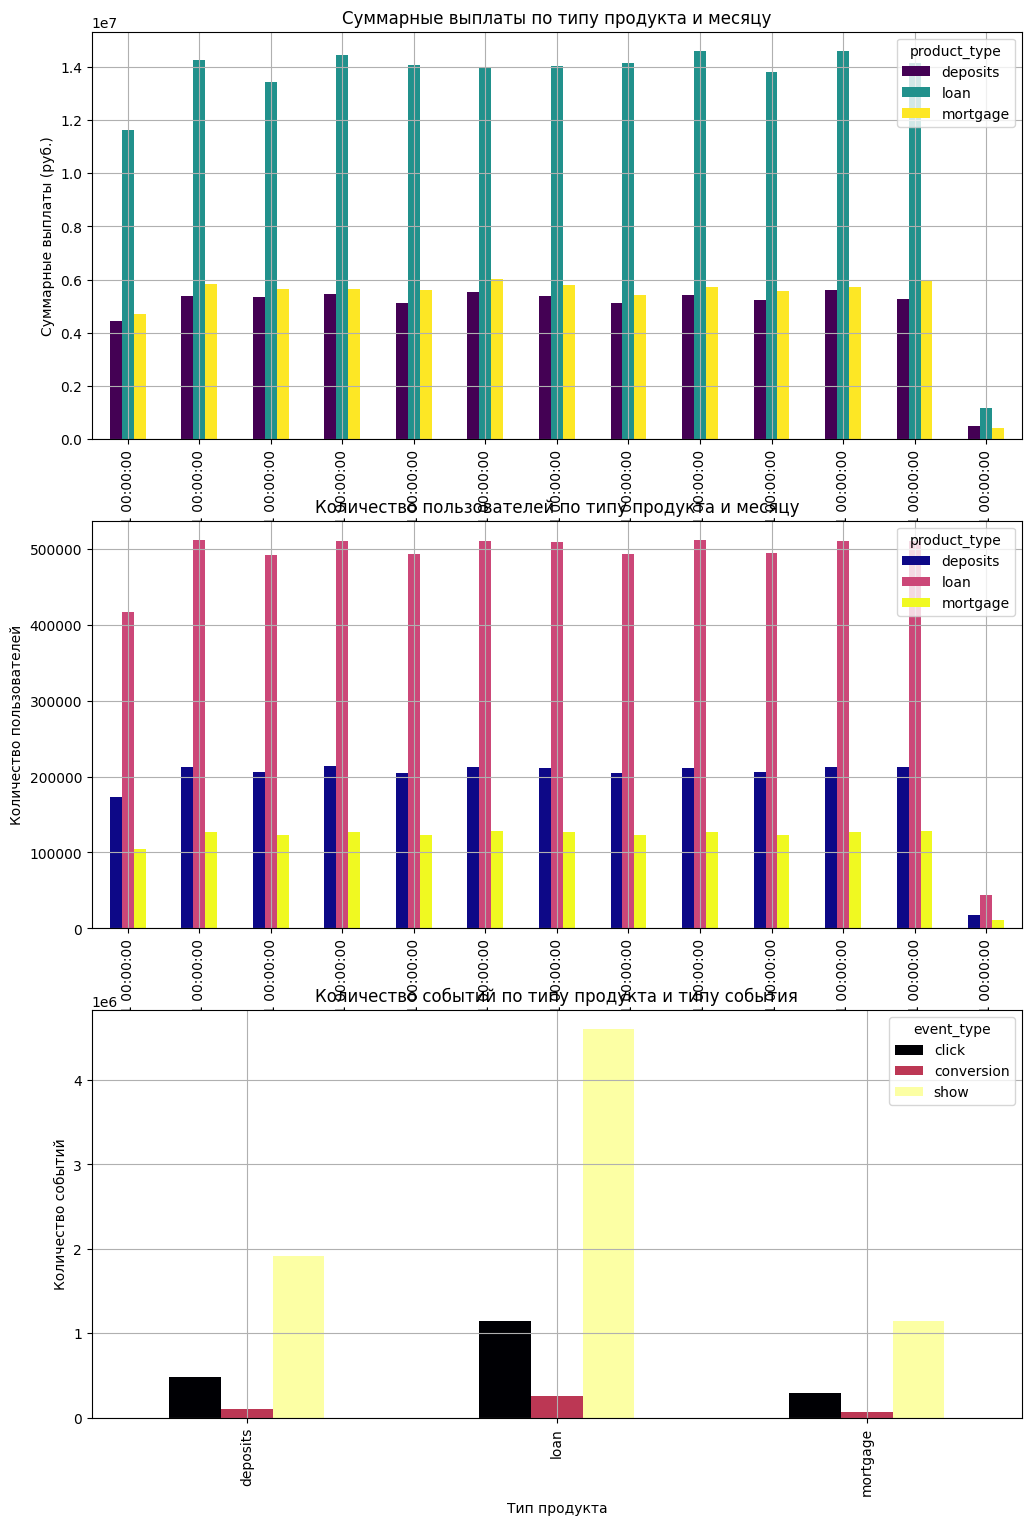

In [40]:
# Создание подграфиков
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Группировка и суммирование данных по типу продукта и месяцу
grouped_payout = event.groupby(['month', 'product_type'])['total_payout_rub'].sum().unstack()
grouped_user_id = event.groupby(['month', 'product_type'])['user_id_cnt'].sum().unstack()
grouped_event_type = event.groupby(['product_type', 'event_type'])['user_id_cnt'].sum().unstack()

# График суммарных выплат по типу продукта
grouped_payout.plot(kind='bar', ax=axs[0], colormap='viridis')
axs[0].set_title('Суммарные выплаты по типу продукта и месяцу')
axs[0].set_xlabel('Месяц')
axs[0].set_ylabel('Суммарные выплаты (руб.)')
axs[0].grid(True)

# График количества пользователей по типу продукта и месяцу
grouped_user_id.plot(kind='bar', ax=axs[1], colormap='plasma')
axs[1].set_title('Количество пользователей по типу продукта и месяцу')
axs[1].set_xlabel('Месяц')
axs[1].set_ylabel('Количество пользователей')
axs[1].grid(True)

# График количества событий по типу продукта и типу события
grouped_event_type.plot(kind='bar', ax=axs[2], colormap='inferno')
axs[2].set_title('Количество событий по типу продукта и типу события')
axs[2].set_xlabel('Тип продукта')
axs[2].set_ylabel('Количество событий')
axs[2].grid(True)

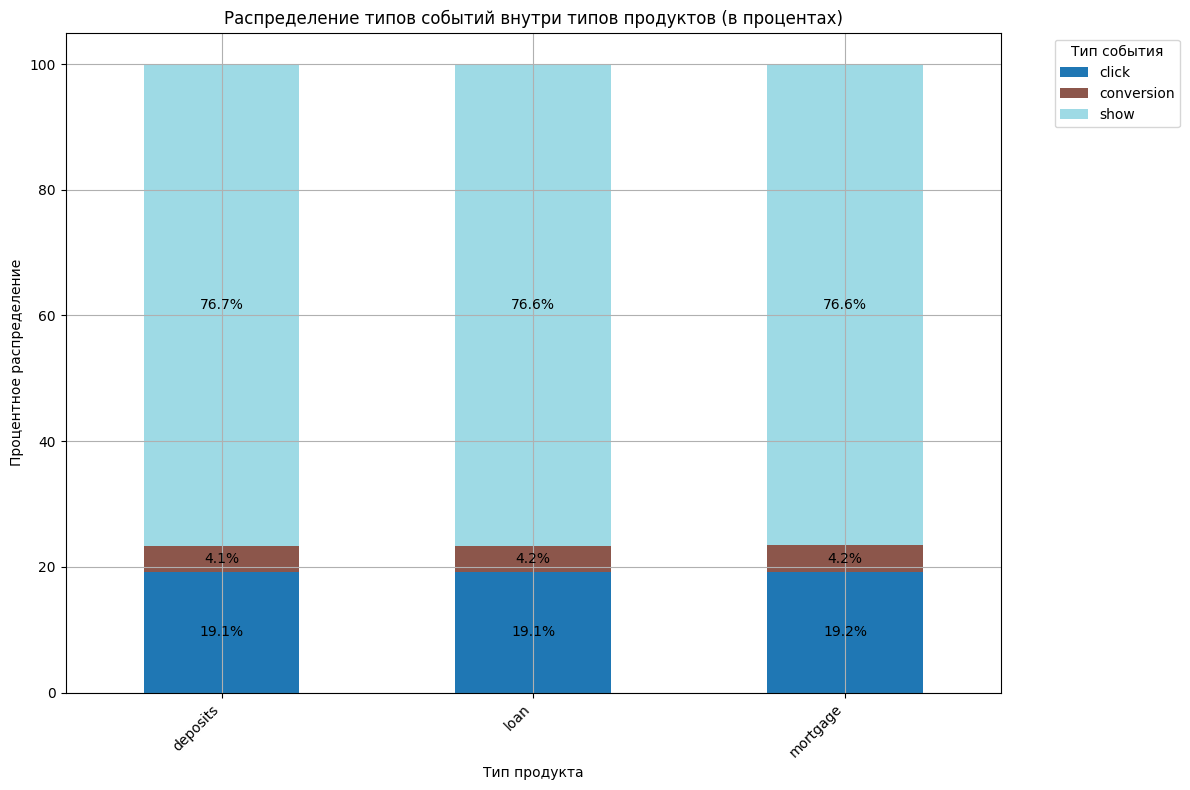

In [44]:
# Группировка данных по типу продукта и типу события и суммирование количества пользователей
grouped = event.groupby(['product_type', 'event_type'])['user_id_cnt'].sum().unstack()

# Нормирование значений для каждого столбца
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Создание графика
fig, ax = plt.subplots(figsize=(12, 8))
grouped_percentage.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# Добавление значений внутри каждого столбца
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.1f}%' for v in container.datavalues], label_type='center')

# Добавление заголовков и меток
plt.title('Распределение типов событий внутри типов продуктов (в процентах)')
plt.xlabel('Тип продукта')
plt.ylabel('Процентное распределение')
plt.legend(title='Тип события', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Отображение графика
plt.tight_layout()
plt.show()

In [42]:
grouped

event_type,click,conversion,show
product_type,,,
deposits,478239,103038,1916309
loan,1149238,253537,4599727
mortgage,288058,63670,1148184


<Figure size 1000x600 with 0 Axes>

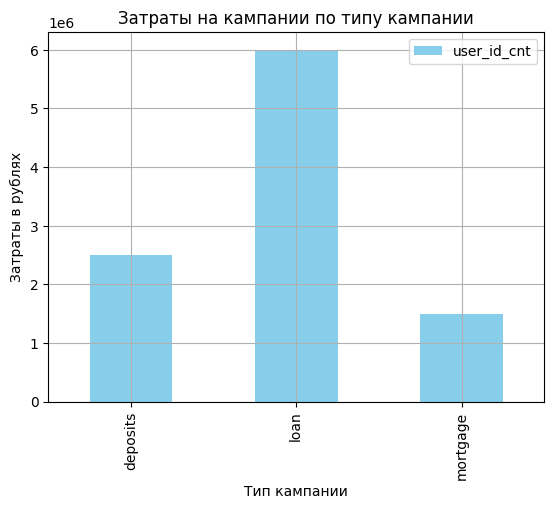

In [38]:
# event.user_id_cnt
# adv.user_id_cnt
# Группировка данных по количеству действий пользователя
#campaign_adv_count = adv.groupby('campaign_type')['user_id_cnt'].sum().sort_values(ascending=False)
campaign_event_count = event.groupby(['product_type'])[['user_id_cnt', 'event_type']].sum() #.sort_values(ascending=False)

# Построение графика затрат по типу кампании
plt.figure(figsize=(10, 6))
#campaign_adv_count.plot(kind='bar')
campaign_event_count.plot(kind='bar', color='skyblue')
plt.title('Затраты на кампании по типу кампании')
plt.xlabel('Тип кампании')
plt.ylabel('Затраты в рублях')
plt.grid(True)
plt.show()


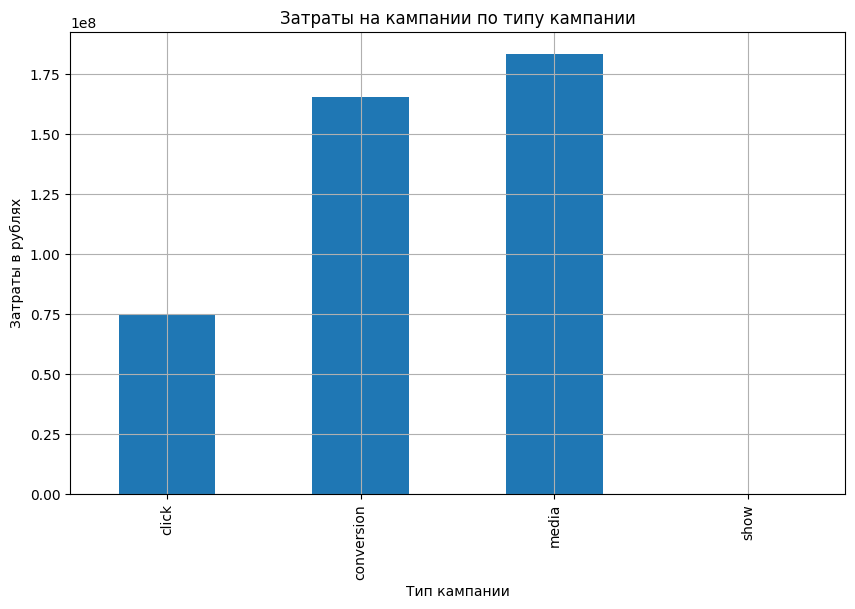

In [27]:
# Группировка данных по типу кампании и суммирование затрат
campaign_adv_costs = adv.groupby('campaign_type')['total_cost_rub'].sum()

# Построение графика затрат по типу кампании
plt.figure(figsize=(10, 6))
campaign_adv_costs.plot(kind='bar')
plt.title('Затраты на кампании по типу кампании')
plt.xlabel('Тип кампании')
plt.ylabel('Затраты в рублях')
plt.grid(True)
plt.show()

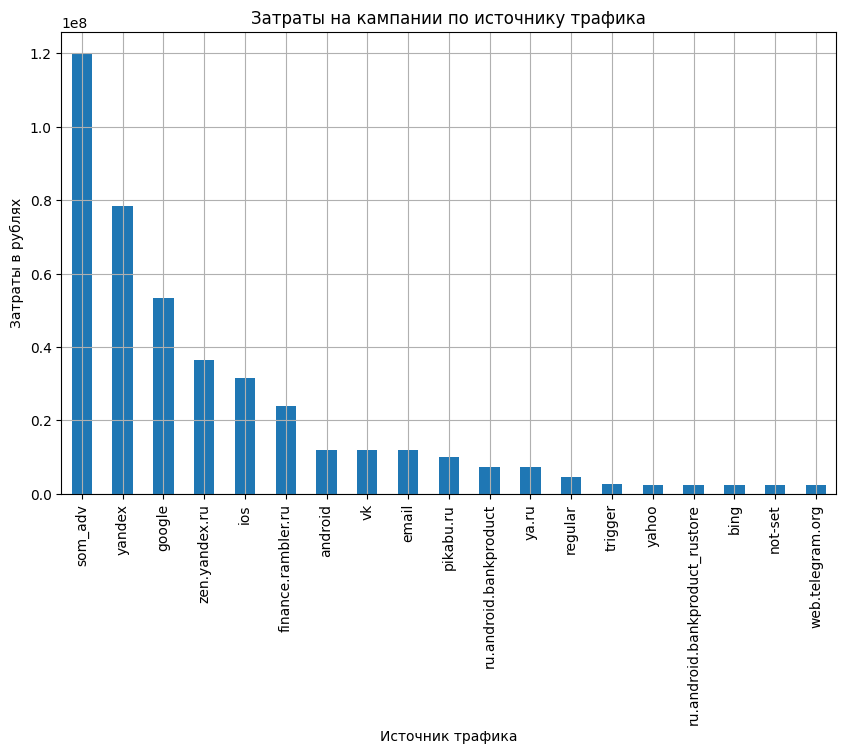

In [19]:
# Группировка данных по источнику трафика и суммирование затрат
source_adv_costs = adv.groupby('source')['total_cost_rub'].sum().sort_values(ascending=False)

# Построение графика затрат по источнику трафика
plt.figure(figsize=(10, 6))
source_adv_costs.plot(kind='bar')
plt.title('Затраты на кампании по источнику трафика')
plt.xlabel('Источник трафика')
plt.ylabel('Затраты в рублях')
plt.grid(True)
plt.show()

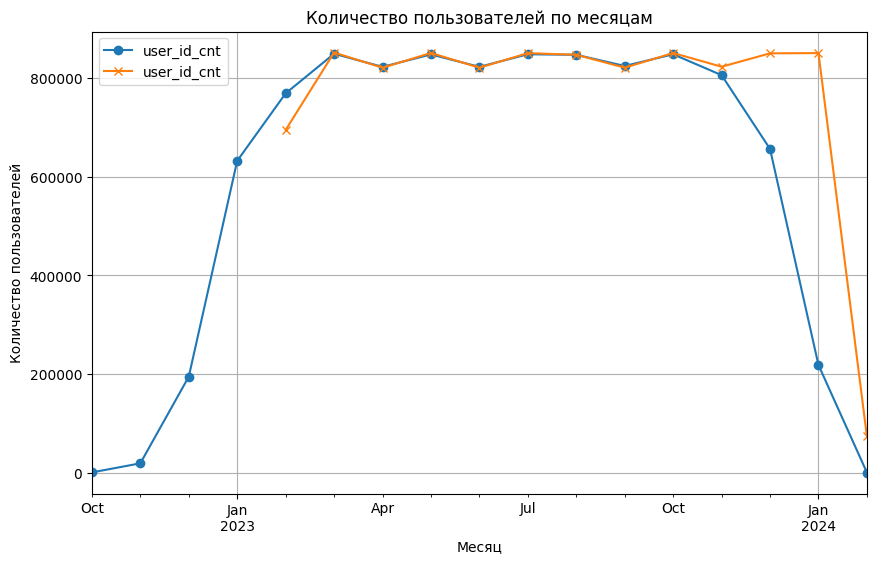

In [18]:
# Группировка данных по месяцам и суммирование количества  пользователей
monthly_event_users = event.groupby('month')['user_id_cnt'].sum()

# Группировка данных по месяцам и суммирование уникальных пользователей
monthly_adv_users = adv.groupby('month')['user_id_cnt'].sum()

# Построение графика количества пользователей по месяцам
plt.figure(figsize=(10, 6))
monthly_adv_users.plot(kind='line', marker='o')
monthly_event_users.plot(kind='line', marker='x')

plt.title('Количество пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(True)
plt.show()